## Estudo das características do ruído no espectrograma (abordagem inicial) - Geração de gráficos das métricas do espectrograma, histograma e espectro de transientes com ruído em função do nível de ruído adicionado.

#### ATENÇÃO: FUNÇÃO DE GERAÇÃO DOS ESPECTROGRAMAS ESTÁ DESATUALIZADA COM RESPEITO A PRESENTE EM utils.py.

### Definições

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from scipy.signal import ShortTimeFFT
from scipy.signal.windows import hann
import random
from scipy.stats import skew
from scipy.stats import kurtosis
import csv
import datetime
import pandas

In [2]:
import data_corruption

In [3]:
def read_data(file_path):
  # Add new data to CSV file
    std = []
    var = []
    dict_metrics = {}
    with open(file_path, mode='r', newline='') as file:
        reader = csv.reader(file, delimiter=',')
        line_count = 0
        for row in reader:
            if line_count == 0:
                head = (row[0].strip('][').split(', '))[2:]
                aux = (row[1].strip('][').split(', '))
                for i in range(0,len(head),2):
                    dict_metrics[str(head[i][6:-1])] = {'mean':[],'std':[]}
            else:
                aux = (row[0].strip('][').split(', '))
            aux2 = [float(i) for i in aux]
            std.append(aux2[0])
            var.append(aux2[1])
            for i in range(0,len(head),2):
                dict_metrics[str(head[i][6:-1])]['mean'].append(aux2[i+2])
                dict_metrics[str(head[i][6:-1])]['std'].append(aux2[i+3])
            line_count += 1
            
    return std,var,dict_metrics

In [4]:
def spect_noise_estimation(spect, qntty, ppm):
  std_array = np.empty(qntty)

  for i in range(qntty):
    idx_noise_1 = np.abs(ppm[i,:] - 8.5).argmin()
    idx_noise_2 = np.abs(ppm[i,:] - 9.5).argmin()
    idx_noise_3 = np.abs(ppm[i,:] - 10.5).argmin()

    #assumes ppm is inverted: smaller values in higher indexes
    ppm_array_1 = ppm[i,idx_noise_2:idx_noise_1]
    ppm_array_2 = ppm[i,idx_noise_3:idx_noise_2]
    spect_array_1 = np.real(spect[i,idx_noise_2:idx_noise_1])
    spect_array_2 = np.real(spect[i,idx_noise_3:idx_noise_2])

    estimate_1 = np.polyfit(ppm_array_1, spect_array_1, 2)
    estimate_2 = np.polyfit(ppm_array_2, spect_array_2, 2)
    aux_1 = (estimate_1[0]*(ppm_array_1**2)) + (estimate_1[1]*ppm_array_1) +  estimate_1[2]
    aux_2 = (estimate_2[0]*(ppm_array_2**2)) + (estimate_2[1]*ppm_array_2) +  estimate_2[2]
    detrending_1 = spect_array_1 - aux_1
    detrending_2 = spect_array_2 - aux_2
    std_1 = np.std(detrending_1)
    std_2 = np.std(detrending_2)

    if np.abs(std_1) < np.abs(std_2):
      std = std_1
    else:
      std = std_2

    std_array[i] = std

  return std_array

def spect_SNR_estimation(spect, qntty, ppm, ppm_min_peak,ppm_max_peak):

  noise_array = spect_noise_estimation(spect, qntty, ppm)
  SNR_array = np.empty(qntty)
  peak_array = np.empty(qntty)

  for i in range(qntty):
    idx_GABA_0 = np.abs(ppm[i,:] - ppm_min_peak).argmin()
    idx_GABA_1 = np.abs(ppm[i,:] - ppm_max_peak).argmin()
    peak_amplitude = np.max(np.abs(np.real(spect[i,idx_GABA_1:idx_GABA_0])))

    SNR = peak_amplitude/(2*noise_array[i])
    SNR_array[i] = SNR
    peak_array[i] = peak_amplitude

  return SNR_array, noise_array, peak_array

In [5]:
def normalize_vector_between_minus_one_and_one(complex_array):
    real_parts = complex_array.real
    imaginary_parts = complex_array.imag

    min_real = np.min(real_parts)
    max_real = np.max(real_parts)
    min_imaginary = np.min(imaginary_parts)
    max_imaginary = np.max(imaginary_parts)

    range_real = max_real - min_real
    range_imaginary = max_imaginary - min_imaginary

    normalized_real = (((real_parts - min_real)/range_real)*2)-1
    normalized_imaginary = (((imaginary_parts - min_imaginary)/range_imaginary)*2)-1

    normalized_complex_array = normalized_real + 1j*normalized_imaginary
    return normalized_complex_array

def normalize_vector_min_max(complex_array):
    real_parts = complex_array.real
    imaginary_parts = complex_array.imag

    min_real = np.min(real_parts)
    max_real = np.max(real_parts)
    min_imaginary = np.min(imaginary_parts)
    max_imaginary = np.max(imaginary_parts)

    range_real = max_real - min_real
    range_imaginary = max_imaginary - min_imaginary

    normalized_real = ((real_parts - min_real)/range_real)
    normalized_imaginary = ((imaginary_parts - min_imaginary)/range_imaginary)

    normalized_complex_array = normalized_real + 1j*normalized_imaginary
    return normalized_complex_array

def normalize_vector_zscore(complex_array):
    real_parts = complex_array.real
    imaginary_parts = complex_array.imag

    mean_real = np.mean(real_parts)
    std_real = np.std(real_parts)
    mean_imaginary = np.mean(imaginary_parts)
    std_imaginary = np.std(imaginary_parts)

    normalized_real = (real_parts - mean_real)/std_real
    normalized_imaginary = (imaginary_parts - mean_imaginary)/std_imaginary

    normalized_complex_array = normalized_real + 1j*normalized_imaginary
    return normalized_complex_array

def get_normalized_spectrogram(fids,bandwidth,qntty,a,b,norm,correct_time):
    w = hann(256, sym=True)
    mfft_ = 446
    SFT = ShortTimeFFT(w, hop=10, fs=bandwidth, mfft=mfft_, scale_to='magnitude', fft_mode = 'centered')
    t_lo, t_hi, f_lo, f_hi = SFT.extent(fids.shape[1])
    spgram = []
    for i in range(qntty):
        aux = SFT.stft(fids[i,:])
        if norm == 'm1p1':
            spgram.append(normalize_vector_between_minus_one_and_one(aux))
        elif norm == 'zscore':
            spgram.append(normalize_vector_zscore(aux))
        elif norm == 'minmax':
            spgram.append(normalize_vector_min_max(aux))
        else:
            spgram.append(aux/np.max(np.abs(aux)))
    spgram = np.array(spgram)
    
    freq_spect = np.flip(np.linspace(f_lo,f_hi,mfft_))
    ppm_spect = a*freq_spect+b
    t_spect = np.linspace(t_lo,t_hi,spgram.shape[2])

    if correct_time == True:
        zero_idx = np.abs(t_spect - 0.0).argmin()
        one_idx = np.abs(t_spect - 1.0).argmin()
        t_spect = t_spect[zero_idx:one_idx]
        spgram = spgram[:,:,zero_idx:one_idx]
    
    return spgram, freq_spect, ppm_spect, t_spect

In [6]:
def center_bins(bins):
    mean_bins = []
    for i in range(bins.shape[0]):
        mean_bins.append([])
        for j in range(bins.shape[1]-1):
            aux = (bins[i,j+1]+bins[i,j])/2
            mean_bins[i].append(aux)
    mean_bins = np.array(mean_bins)
    return mean_bins

In [7]:
def get_histogram(spgram,qntty):
    
    hist = []
    bins_hist = []
    for i in range(qntty):
        #switched from 200 to 8000, from density to absolute
        aux, bins = np.histogram(np.real(spgram[i,:,:]), 8000)
        #added this normalization
        aux = aux/aux.sum()
        hist.append(aux)
        bins_hist.append(bins)
    hist = np.array(hist)
    bins_hist = np.array(bins_hist)

    bins_ = center_bins(bins_hist)
    return hist, bins_

In [8]:
def calculate_TVs(spgram):
  aux_delta_l = np.empty(spgram.shape)
  for i in range(spgram.shape[1]-1):
    aux = np.real(spgram[:,i+1,:]-spgram[:,i,:])
    aux_delta_l[:,i,:]=aux
  aux_delta_l[:,-1,:] = np.zeros((spgram.shape[0],spgram.shape[2]))
  aux_delta_c = np.empty(spgram.shape)
  for i in range(spgram.shape[2]-1):
    aux = np.real(spgram[:,:,i+1]-spgram[:,:,i])
    aux_delta_c[:,:,i]=aux
  aux_delta_c[:,:,-1] = np.zeros((spgram.shape[0],spgram.shape[1]))
  TV_aniso = np.sum(np.abs(aux_delta_l)+np.abs(aux_delta_c), axis =(1,2))
  TV_iso = np.sum(np.sqrt((np.abs(aux_delta_l)**2)+(np.abs(aux_delta_c)**2)), axis=(1,2))

  return TV_aniso, TV_iso

In [9]:
def stats(seq_stats,names):

  metrics = {}
  for i,value in enumerate(seq_stats):
    metrics[names[i]] = {}
    metrics[names[i]]['mean'] = np.mean(value)
    metrics[names[i]]['std'] = np.std(value)

  return metrics

In [10]:
def get_histogram_metrics(hist,bins):
    #no median, no range, no cov, new skew (corrected), new kurt (corrected), added max, added LWHM
    argmax_hist = np.argmax(hist,axis=1)
    mode_ = []
    for i in range(argmax_hist.shape[0]):
        mode_.append(bins[i,argmax_hist[i]]) #pixel value that happens the most
    mode_ = np.array(mode_)
    max_ = np.max(hist,axis=1) #peak amplitude

    LWHM_ = []
    value_ref_larg = 1e-4
    for i in range(hist.shape[0]):
        aux_ans_min = 10000000
        aux_idx_min = 0
        aux_ans_max= 10000000
        aux_idx_max = 0
        for j in range(argmax_hist[i]):
            if np.abs(hist[i,j] - value_ref_larg) < aux_ans_min:
                aux_ans_min = np.abs(hist[i,j] - value_ref_larg)
                aux_idx_min = j
        for j in range(argmax_hist[i],hist.shape[1]):
            if np.abs(hist[i,j] - value_ref_larg) < aux_ans_max:
                aux_ans_max = np.abs(hist[i,j] - value_ref_larg)
                aux_idx_max = j
        LWHM_.append(np.abs(bins[i,aux_idx_max]-bins[i,aux_idx_min]))
    LWHM_ = np.array(LWHM_) #linewidth

    
    mean_ = np.sum(bins*hist,axis=1)
    std_ = np.sqrt(np.sum(((bins - mean_[:, np.newaxis])**2)*hist,axis=1))
    skewness_ = np.sum(((bins - mean_[:, np.newaxis])/std_[:, np.newaxis])**3*hist,axis=1)
    kurtosis_ = np.sum(((bins - mean_[:, np.newaxis])/std_[:, np.newaxis])**4*hist,axis=1)
    
    names = ['mode','max','width','skewness','kurtosis']
    seq_stats = (mode_,max_,LWHM_,skewness_,kurtosis_)
    metrics = stats(seq_stats,names)

    return metrics

In [11]:
def get_spgram_metrics(spgram,time,ppm):
  mean_ = np.mean(np.real(spgram),axis = (1,2))
  median_ = np.median(np.real(spgram),axis = (1,2))
  std_ = np.std(np.real(spgram),axis = (1,2))
  trace_ = []
  for i in range(spgram.shape[0]):
    trace_.append(np.trace(np.cov(np.real(spgram[i,:,:]))))
  trace_ = np.array(trace_)
  TV_aniso,TV_iso = calculate_TVs(spgram)

  idx_time_1 = np.abs(time - 0.4).argmin()
  idx_time_2 = np.abs(time - 0.6).argmin()
  idx_freq_1 = np.abs(np.flip(ppm) - 1).argmin()
  idx_freq_2 = np.abs(np.flip(ppm) - 8).argmin()
  sum_late = np.sum(np.abs(np.real(spgram[:,:,idx_time_2:])),axis=(1,2))
  #changed mean late and std late || before np.mean(np.abs(np.real(
  mean_late = np.mean(np.real(spgram[:,:,idx_time_2:]),axis=(1,2))
  std_late = np.std(np.real(spgram[:,:,idx_time_2:]),axis=(1,2))
  TV_aniso_late,TV_iso_late = calculate_TVs(spgram[:,idx_freq_1:idx_freq_2,idx_time_2:])
  #changed mean main and std main || before np.mean(np.abs(np.real(
  mean_main_sig = np.mean(np.real(spgram[:,idx_freq_1:idx_freq_2,:idx_time_1]),axis=(1,2))
  std_main_sig = np.std(np.real(spgram[:,idx_freq_1:idx_freq_2,:idx_time_1]),axis=(1,2))
  TV_aniso_main_sig,TV_iso_main_sig = calculate_TVs(spgram[:,idx_freq_1:idx_freq_2,:idx_time_1])

  names = ['MEAN_total','median_total','STD_total','trace_total','TV_aniso_total','TV_iso_total',
           'sum_late','MEAN_late','STD_late','TV_aniso_late','TV_iso_late',
           'MEAN_main_sig','STD_main_sig','TV_aniso_main_sig','TV_iso_main_sig']
  seq_stats = (mean_,median_,std_,trace_,TV_aniso,TV_iso,
               sum_late,mean_late,std_late,TV_aniso_late,TV_iso_late,
               mean_main_sig,std_main_sig,TV_aniso_main_sig,TV_iso_main_sig)
  metrics = stats(seq_stats,names)

  return metrics

### Extrai dados dos arquivos com as métricas:

In [12]:
path_gt_file = '../sample_data.h5'

In [13]:
qntty = 200

In [14]:
#Import data obtained on EditedMRS_Reconstruction_Challenge github -- Ground-truths
with h5py.File(path_gt_file) as hf:
  print(hf.keys())
  gt_fids = hf["ground_truth_fids"][()][:qntty]
  ppm = hf["ppm"][()][:qntty]
  t = hf["t"][()][:qntty]
  print(gt_fids.shape)
  print(ppm.shape)
  print(t.shape)

<KeysViewHDF5 ['ground_truth_fids', 'ppm', 't']>
(200, 2048, 2)
(200, 2048)
(200, 2048)


In [23]:
file_spectrum_path = 'data_Real_Norm_ABS_STFT_FID_spectrum_timecorrected.csv'
file_hist_path = 'data_Real_Norm_ABS_STFT_FID_hist_timecorrected.csv' 
file_spgram_path = 'data_Real_Norm_ABS_STFT_FID_spgram_timecorrected.csv' 

In [24]:
def from_list_to_array(dict_data):
    keys = list(dict_data.keys())
    for key in keys:
        aux1 = np.array(dict_data[key]['mean'])
        aux2 = np.array(dict_data[key]['std'])
        dict_data[key]['mean'] = aux1
        dict_data[key]['std'] = aux2

    return dict_data

In [25]:
std,var, metrics_spectrum_corrupted_avgs = read_data(file_spectrum_path)
std,var, metrics_hist_corrupted_avgs = read_data(file_hist_path)
std,var, metrics_spgram_corrupted_avgs = read_data(file_spgram_path)
metrics_spectrum_corrupted_avgs = from_list_to_array(metrics_spectrum_corrupted_avgs)
metrics_hist_corrupted_avgs = from_list_to_array(metrics_hist_corrupted_avgs)
metrics_spgram_corrupted_avgs = from_list_to_array(metrics_spgram_corrupted_avgs)
std = np.array(std)
var = np.array(var)

### Gera métricas de dados sem ruído para comparação:

In [26]:
#general
dwelltime = t[0,1]-t[0,0]
bandwidth = 1/dwelltime
N = gt_fids.shape[1]

#gts
spectra_gt_fids = np.fft.fftshift(np.fft.ifft(gt_fids,n=N,axis = 1), axes = 1)
spectra_gt_diff = spectra_gt_fids[:,:,1] - spectra_gt_fids[:,:,0]
freq = np.flip(np.fft.fftshift(np.fft.fftfreq(N, d = dwelltime)))

#to get ppm axis
idx_min = np.real(spectra_gt_diff[0,:]).argmin()
idx_max = np.real(spectra_gt_diff[0,:]).argmax()
#p = a*f + b
a = (ppm[0,idx_max] - ppm[0,idx_min])/(freq[idx_max]-freq[idx_min])
b = ppm[0,idx_max] - a*freq[idx_max]

names_stats_spectrum = ['SNR','STD','peak']
names_stats_hist = ['mode','max','width','skewness','kurtosis']
names_stats_spgram = ['MEAN_total','median_total','STD_total','trace_total','TV_aniso_total','TV_iso_total',
           'sum_late','MEAN_late','STD_late','TV_aniso_late','TV_iso_late',
           'MEAN_main_sig','STD_main_sig','TV_aniso_main_sig','TV_iso_main_sig']

SNR_gt, std_gt, peak_gt = spect_SNR_estimation(spectra_gt_diff, qntty, ppm, 2.79, 3.55)
metrics_spectrum_gt = stats((SNR_gt, std_gt, peak_gt),names_stats_spectrum)

gt_fids_diff = gt_fids[:,:,1]-gt_fids[:,:,0]
spgram_gt, freq_spect, ppm_spect, t_spect = get_normalized_spectrogram(gt_fids_diff,bandwidth,qntty,a,b,'abs',True)
metrics_spgram_gt = get_spgram_metrics(spgram_gt,t_spect,ppm_spect)

hist_gt, bins_hist = get_histogram(spgram_gt,qntty)
metrics_hist_gt = get_histogram_metrics(hist_gt,bins_hist)

### Gráficos métricas do espectro:

In [27]:
test_idx = np.arange(std.shape[0])

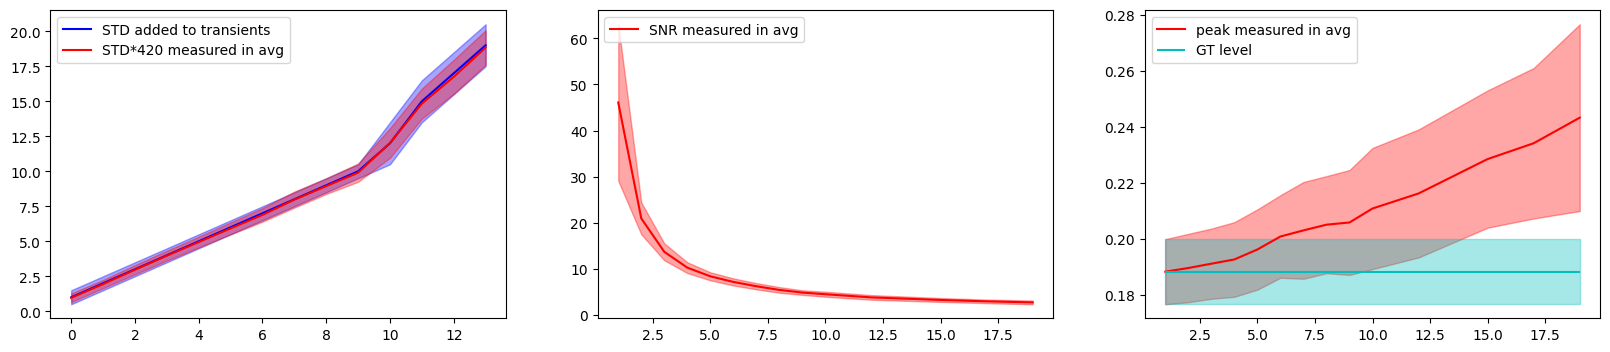

In [34]:
fig, ax = plt.subplots(1,3,figsize=(20,4))

ax[0].plot(std,color='blue', label = 'STD added to transients')
ax[0].fill_between(test_idx, std - var, std + var, alpha=0.35, color = 'blue')
ax[0].plot(metrics_spectrum_corrupted_avgs['STD']['mean']*420,color='red', label = 'STD*420 measured in avg')
ax[0].fill_between(test_idx, metrics_spectrum_corrupted_avgs['STD']['mean']*420 - metrics_spectrum_corrupted_avgs['STD']['std']*420, 
                   metrics_spectrum_corrupted_avgs['STD']['mean']*420 + metrics_spectrum_corrupted_avgs['STD']['std']*420, alpha=0.35, color = 'red')
ax[0].legend(loc='upper left')

ax[1].plot(std,metrics_spectrum_corrupted_avgs['SNR']['mean'],color='red', label = 'SNR measured in avg')
ax[1].fill_between(std, metrics_spectrum_corrupted_avgs['SNR']['mean'] - metrics_spectrum_corrupted_avgs['SNR']['std'], 
                   metrics_spectrum_corrupted_avgs['SNR']['mean'] + metrics_spectrum_corrupted_avgs['SNR']['std'], alpha=0.35, color = 'red')
ax[1].legend(loc='upper left')


ax[2].plot(std,metrics_spectrum_corrupted_avgs['peak']['mean'],color='red', label = 'peak measured in avg')
ax[2].fill_between(std, metrics_spectrum_corrupted_avgs['peak']['mean'] - metrics_spectrum_corrupted_avgs['peak']['std'], 
                   metrics_spectrum_corrupted_avgs['peak']['mean'] + metrics_spectrum_corrupted_avgs['peak']['std'], alpha=0.35, color = 'red')
ax[2].hlines(metrics_spectrum_gt['peak']['mean'],std[0],std[-1],color='c',label='GT level')
ax[2].fill_between(std, metrics_spectrum_gt['peak']['mean'] - metrics_spectrum_gt['peak']['std'], 
                   metrics_spectrum_gt['peak']['mean'] + metrics_spectrum_gt['peak']['std'], alpha=0.35, color = 'c')
ax[2].legend(loc='upper left')

### Gráficos métricas do histograma:

(0.0, 1.0, 0.0, 1.0)

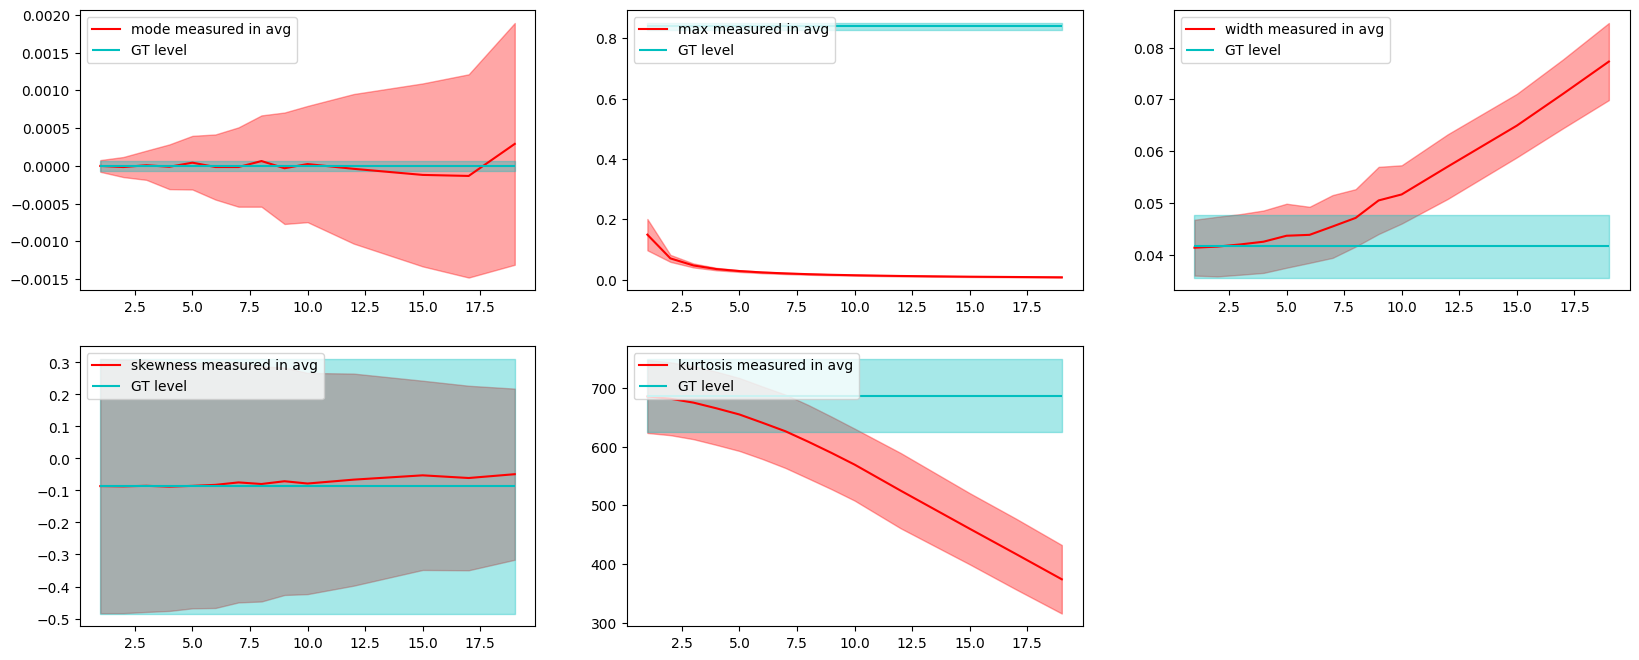

In [29]:
fig, ax = plt.subplots(2,3,figsize=(20,8))

for i in range(len(names_stats_hist)):
    ax.flat[i].plot(std,metrics_hist_corrupted_avgs[names_stats_hist[i]]['mean'],color='red', label = names_stats_hist[i]+' measured in avg')
    ax.flat[i].fill_between(std, metrics_hist_corrupted_avgs[names_stats_hist[i]]['mean'] - metrics_hist_corrupted_avgs[names_stats_hist[i]]['std'], 
                       metrics_hist_corrupted_avgs[names_stats_hist[i]]['mean'] + metrics_hist_corrupted_avgs[names_stats_hist[i]]['std'], alpha=0.35, color = 'red')
    ax.flat[i].hlines(metrics_hist_gt[names_stats_hist[i]]['mean'],std[0],std[-1],color='c',label='GT level')
    ax.flat[i].fill_between(std, metrics_hist_gt[names_stats_hist[i]]['mean'] - metrics_hist_gt[names_stats_hist[i]]['std'], 
                       metrics_hist_gt[names_stats_hist[i]]['mean'] + metrics_hist_gt[names_stats_hist[i]]['std'], alpha=0.35, color = 'c')
    ax.flat[i].legend(loc='upper left')

ax[1,2].axis('off')

### Gráficos métricas do espectrograma:

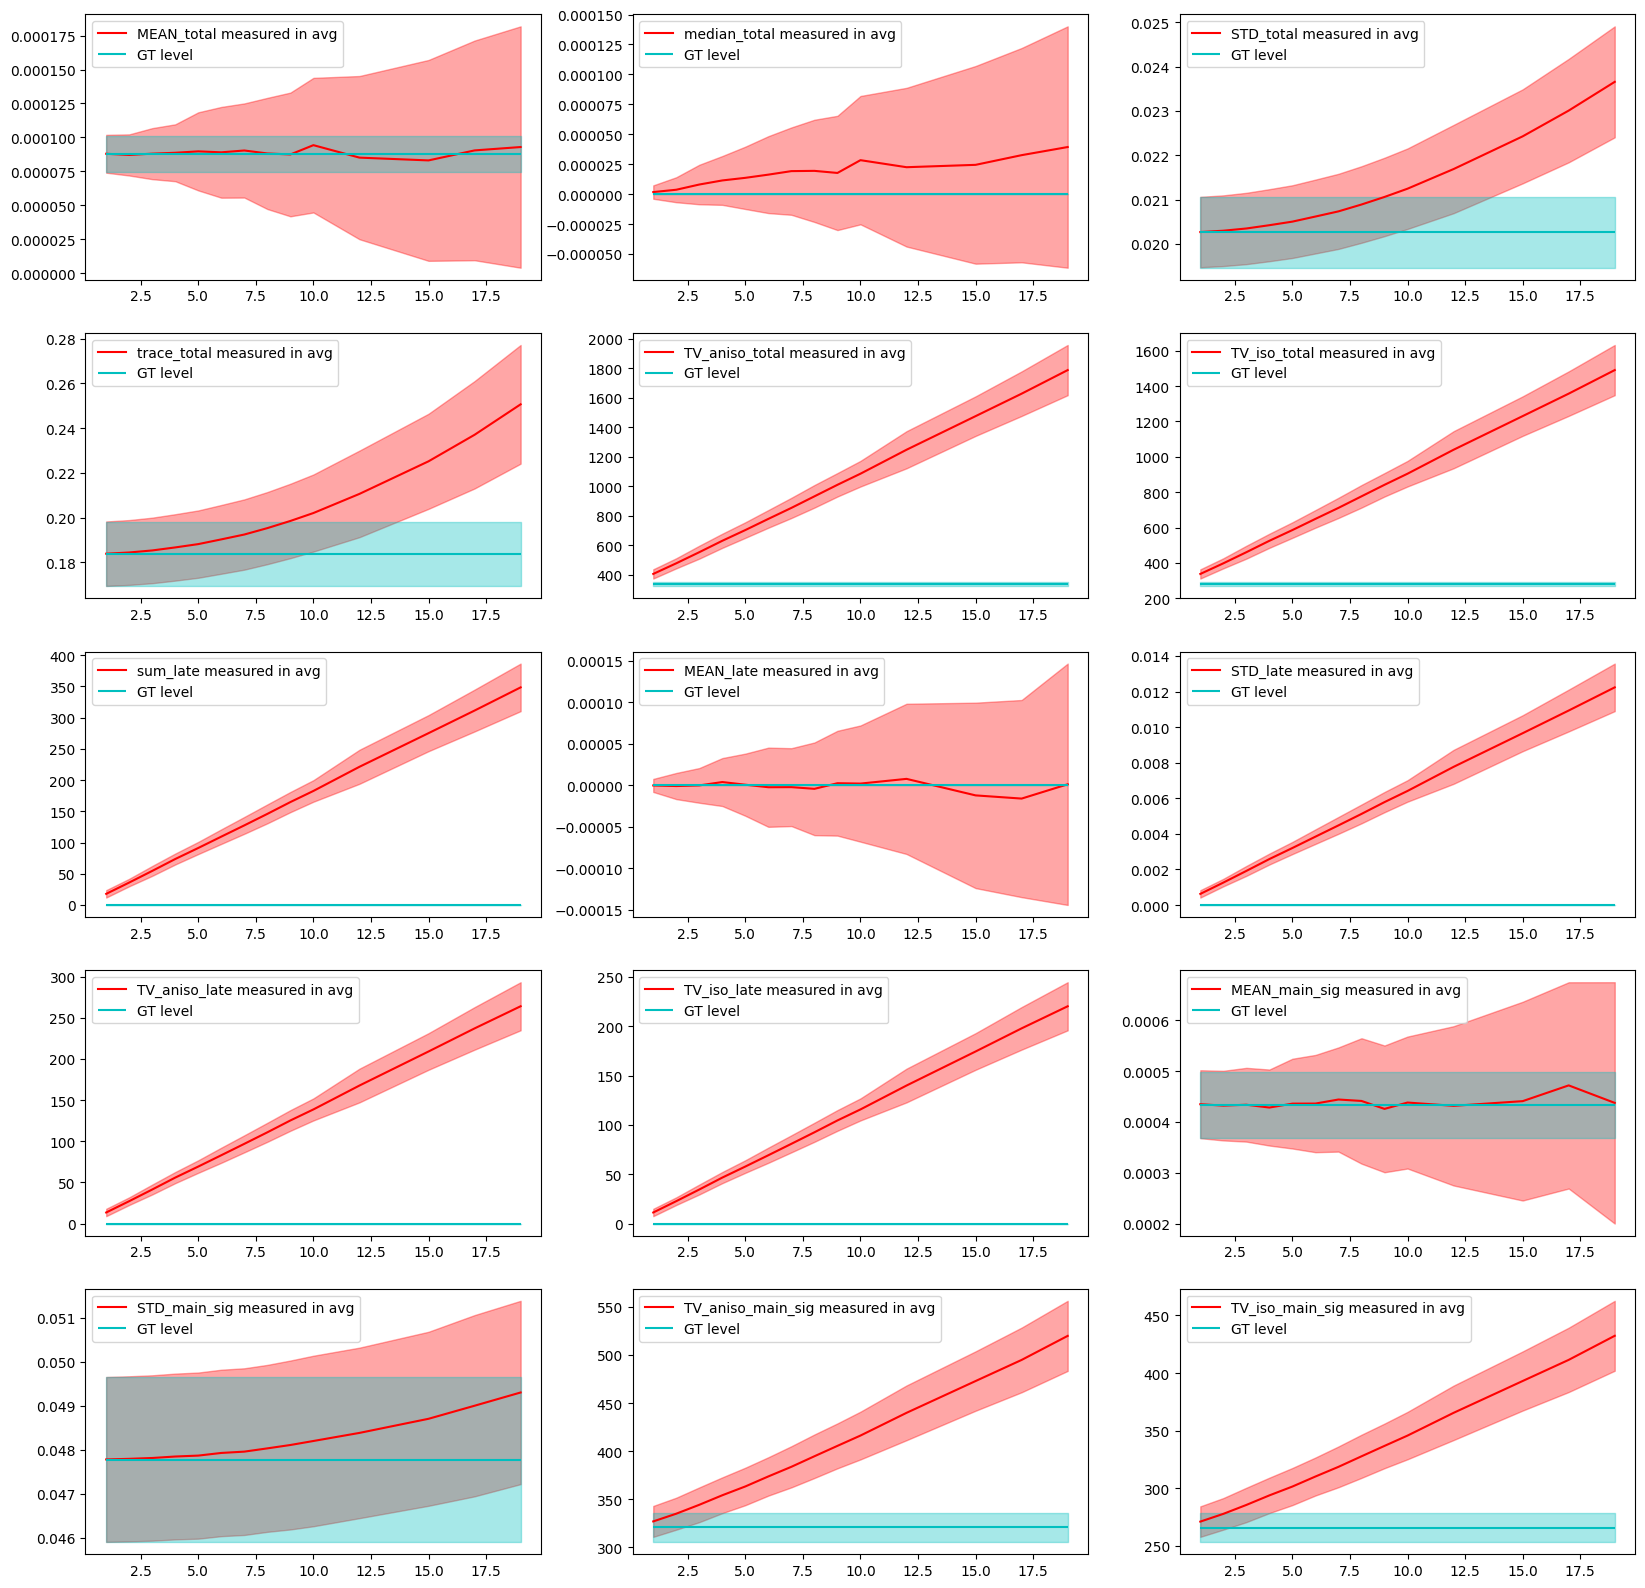

In [30]:
fig, ax = plt.subplots(5,3,figsize=(20,20))

for i in range(len(names_stats_spgram)):
    ax.flat[i].plot(std,metrics_spgram_corrupted_avgs[names_stats_spgram[i]]['mean'],color='red', label = names_stats_spgram[i]+' measured in avg')
    ax.flat[i].fill_between(std, metrics_spgram_corrupted_avgs[names_stats_spgram[i]]['mean'] - metrics_spgram_corrupted_avgs[names_stats_spgram[i]]['std'], 
                       metrics_spgram_corrupted_avgs[names_stats_spgram[i]]['mean'] + metrics_spgram_corrupted_avgs[names_stats_spgram[i]]['std'], alpha=0.35, color = 'red')
    ax.flat[i].hlines(metrics_spgram_gt[names_stats_spgram[i]]['mean'],std[0],std[-1],color='c',label='GT level')
    ax.flat[i].fill_between(std, metrics_spgram_gt[names_stats_spgram[i]]['mean'] - metrics_spgram_gt[names_stats_spgram[i]]['std'], 
                       metrics_spgram_gt[names_stats_spgram[i]]['mean'] + metrics_spgram_gt[names_stats_spgram[i]]['std'], alpha=0.35, color = 'c')
    ax.flat[i].legend(loc='upper left')

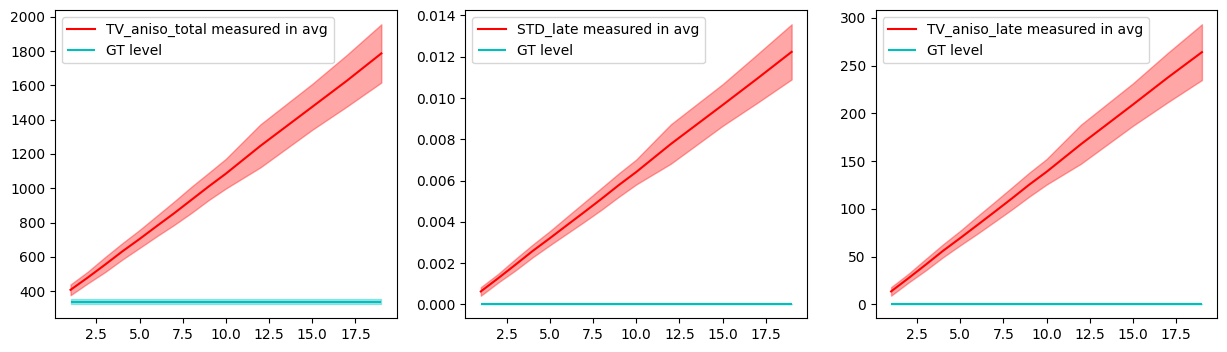

In [31]:
fig, ax = plt.subplots(1,3,figsize=(15,4))

names_aux = ['TV_aniso_total','STD_late','TV_aniso_late']

for i in range(len(names_aux)):
    ax.flat[i].plot(std,metrics_spgram_corrupted_avgs[names_aux[i]]['mean'],color='red', label = names_aux[i]+' measured in avg')
    ax.flat[i].fill_between(std, metrics_spgram_corrupted_avgs[names_aux[i]]['mean'] - metrics_spgram_corrupted_avgs[names_aux[i]]['std'], 
                       metrics_spgram_corrupted_avgs[names_aux[i]]['mean'] + metrics_spgram_corrupted_avgs[names_aux[i]]['std'], alpha=0.35, color = 'red')
    ax.flat[i].hlines(metrics_spgram_gt[names_aux[i]]['mean'],std[0],std[-1],color='c',label='GT level')
    ax.flat[i].fill_between(std, metrics_spgram_gt[names_aux[i]]['mean'] - metrics_spgram_gt[names_aux[i]]['std'], 
                       metrics_spgram_gt[names_aux[i]]['mean'] + metrics_spgram_gt[names_aux[i]]['std'], alpha=0.35, color = 'c')
    ax.flat[i].legend(loc='upper left')

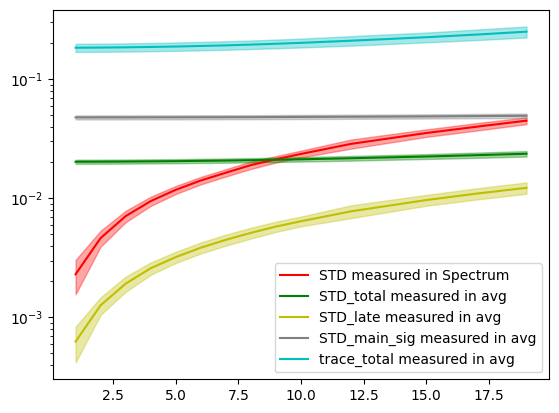

In [32]:
plt.plot(std,metrics_spectrum_corrupted_avgs['STD']['mean'],color='red', label = 'STD measured in Spectrum')
plt.fill_between(std, metrics_spectrum_corrupted_avgs['STD']['mean'] - metrics_spectrum_corrupted_avgs['STD']['std'], 
                   metrics_spectrum_corrupted_avgs['STD']['mean'] + metrics_spectrum_corrupted_avgs['STD']['std'], alpha=0.35, color = 'red')

names_aux = ['STD_total','STD_late','STD_main_sig','trace_total']
color_aux = ['g','y','grey','c']
for i in range(len(names_aux)):
    plt.plot(std,metrics_spgram_corrupted_avgs[names_aux[i]]['mean'],color=color_aux[i], label = names_aux[i]+' measured in avg')
    plt.fill_between(std, metrics_spgram_corrupted_avgs[names_aux[i]]['mean'] - metrics_spgram_corrupted_avgs[names_aux[i]]['std'], 
                       metrics_spgram_corrupted_avgs[names_aux[i]]['mean'] + metrics_spgram_corrupted_avgs[names_aux[i]]['std'], alpha=0.35, color = color_aux[i])

plt.legend(loc='lower right')
plt.yscale('log')

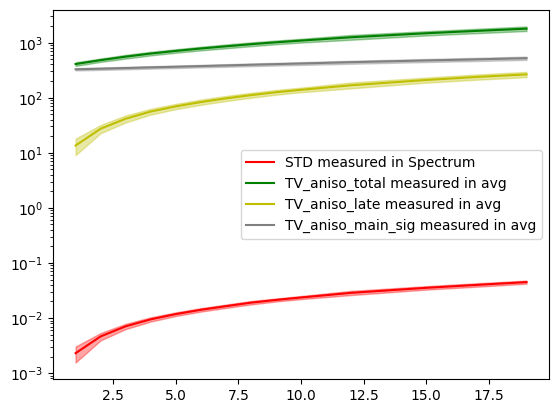

In [33]:
plt.plot(std,metrics_spectrum_corrupted_avgs['STD']['mean'],color='red', label = 'STD measured in Spectrum')
plt.fill_between(std, metrics_spectrum_corrupted_avgs['STD']['mean'] - metrics_spectrum_corrupted_avgs['STD']['std'], 
                   metrics_spectrum_corrupted_avgs['STD']['mean'] + metrics_spectrum_corrupted_avgs['STD']['std'], alpha=0.35, color = 'red')
names_aux =  ['TV_aniso_total','TV_aniso_late','TV_aniso_main_sig']
#names_aux =  ['TV_iso_total','TV_iso_late','TV_iso_main_sig']
color_aux = ['g','y','grey']
for i in range(len(names_aux)):
    plt.plot(std,metrics_spgram_corrupted_avgs[names_aux[i]]['mean'],color=color_aux[i], label = names_aux[i]+' measured in avg')
    plt.fill_between(std, metrics_spgram_corrupted_avgs[names_aux[i]]['mean'] - metrics_spgram_corrupted_avgs[names_aux[i]]['std'], 
                       metrics_spgram_corrupted_avgs[names_aux[i]]['mean'] + metrics_spgram_corrupted_avgs[names_aux[i]]['std'], alpha=0.35, color = color_aux[i])
plt.legend(loc='center right')
plt.yscale('log')